In [2]:
import pandas as pd
import numpy as np
from field_importer import get_field
import pickle
from cartoplot import cartoplot
import mask
from tqdm import trange
from math import sin, cos, sqrt, radians
import os
import xarray as xr
from netCDF4 import Dataset
import numpy.ma as ma
import matplotlib.pyplot as plt
import regrid

In [4]:
# OSISAF goes back to 03/2005, CDS back to 03/2002, Envisat to 10/2002

yearlist = list(range(2002,2019))
print(yearlist)
resolution = (361,361)

monthlist_full = ["01","02","03","04","10","11","12"]
monthlist_start = ["03","04","10","11","12"]
monthlist_end = ["01","02","03"]

mW99 = {"depth":{},"density":{},"SWE":{}}

for year in yearlist:
    
    print(year)
    
    #########################################
    
    # DECIDE WHICH ICE TYPE DATA TO USE
    
    if year == 2006 and int(month) < 3:
        
        type_data = 'cds'
        
    elif year < 2006:
        
        type_data = 'cds'
    
    else:
        
        type_data = 'osisaf'
        
    ##########################################
    
    # DON'T CONSIDER PERIOD BEFORE ENVISAT LAUNCH
    
    if year == 2002:
        
        monthlist = monthlist_start
        
    else:
        
        monthlist = monthlist_full
    
    # Make some empty arrays and fill with nans

    mW99['depth'] = np.full((len(monthlist),resolution[0],resolution[1]), np.nan)
    mW99['density'] = np.full((len(monthlist),resolution[0],resolution[1]), np.nan)
    mW99['SWE'] = np.full((len(monthlist),resolution[0],resolution[1]), np.nan)
        
        
    ###########################################
    
    for counter, month in enumerate(monthlist):
        
        # Get W99 data for that month
        
        W99_depth = get_field('W99', month = month, year = year, 
                              variable='depth', resolution = 361)['field']

        
        W99_SWE = get_field('W99', month = month, year = year,
                              variable='SWE', resolution = 361)['field']
        
        
        W99_density = np.divide(W99_SWE,W99_depth)
        
        # Get OSISAF type data

        ice_type = get_field(type_data,
                                 month,
                                 year,
                                 resolution=361,
                                 variable='Sea_Ice_Type')['field']
        
        # MASK ARRAYS WHERE ICE TYPE IS OPEN WATER OR UNKNOWN
        
        W99_depth = ma.masked_where(ice_type < 2, W99_depth)
        W99_depth = np.ma.filled(W99_depth.astype(float), np.nan)
        W99_density = ma.masked_where(ice_type < 2, W99_density)
        W99_density = np.ma.filled(W99_density.astype(float), np.nan)
        W99_SWE = ma.masked_where(ice_type < 2, W99_SWE)
        W99_SWE = np.ma.filled(W99_SWE.astype(float), np.nan)

        
        # CREATE FYI MASK OF 1 EVERYWHERE APART FROM 0.5 OVER FYI
        
        FYI = ma.masked_where(ice_type != 2, np.full((resolution),0.5))
        FYI = np.ma.filled(FYI.astype(float), 1)
        
        mW_depth = np.multiply(FYI,W99_depth)
        mW_SWE = np.multiply(FYI,W99_SWE)

        
        # Now clean the data where negative snow depths and swe's occur
        

        mW_depth_clean = ma.masked_where(mW_depth <0, mW_depth)
        mW_depth_clean = np.ma.filled(mW_depth_clean.astype(float), 0)
        
        mW_SWE_clean = ma.masked_where(mW_SWE <0, mW_SWE)
        mW_SWE_clean = np.ma.filled(mW_SWE_clean.astype(float), 0)
        
        
        # Put final data into dictionary ready for output

        mW99['depth'][counter] = mW_depth_clean
        mW99['density'][counter] = W99_density
        mW99['SWE'][counter] = mW_SWE_clean
    
    # SAVE THE YEAR'S DATA AS NETCDF
    
    monthlist_ints = []
    for i in monthlist:
        monthlist_ints.append(int(i))
    
    ds = xr.Dataset( data_vars={'depth':(['t','x','y'],mW99['depth']),
                                'density':(['t','x','y'],mW99['density']),
                                'SWE':(['t','x','y'],mW99['SWE'])},
                    
                         coords={'lon':(['x','y'],mask.get('lon')),
                                 'lat':(['x','y'],mask.get('lat')),
                                 'month':(['t'],monthlist_ints)})
    
    data_dir = '/home/robbie/Dropbox/SM_Thickness/data/W99/mW99_361/'
    
    ds.to_netcdf(f'{data_dir}{year}_mW99.nc','w')
    
    # GET THIS DATA WITH ds_month = ds.where(10 == ds.month, drop=True)

[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
2002


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2003


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2004


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2005


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2006


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2007


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2008


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2009


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2010


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2011


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2012


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2013


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2014


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2015


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value 

2016


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

2017


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value 

2018


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in less
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value 

test


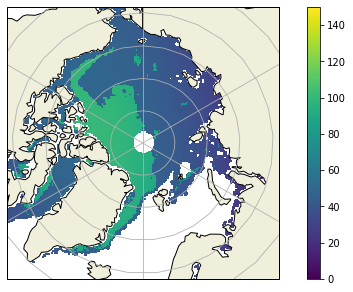

In [9]:
data = get_field('mw99',month="02",year=2012,variable='SWE',resolution=361)

cartoplot(data['lon'],data['lat'],data['field'],color_scale=(0,150))

# Test the dataset

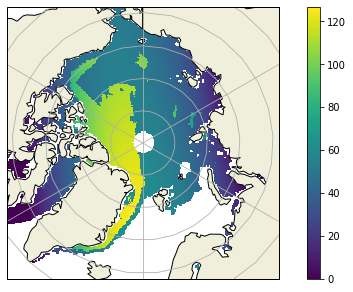

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


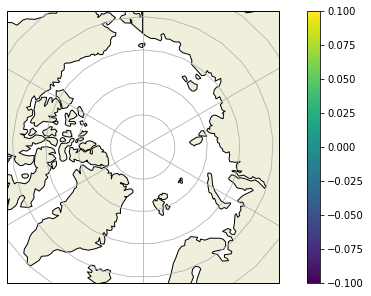

[]


In [13]:
d = get_field('mw99',year=2012,month="04",variable='SWE',resolution=361)

cartoplot(d['lon'],d['lat'],d['field'])

masked = ma.masked_where(d['field'] >= 0, d['field'])
masked = np.ma.filled(masked.astype(float), np.nan)

cartoplot(d['lon'],d['lat'],masked)

serial_data = masked.ravel()

not_nan_array = ~ np.isnan(serial_data)

clean_array = serial_data[not_nan_array]

print(clean_array)